# Libraries and dependencies

In [ ]:
pip install -r requirements.txt

In [ ]:
import os
import re
from dataclasses import dataclass
from typing import Dict, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import librosa

import torch

from jiwer import wer, cer
from tqdm import tqdm

from datasets import Dataset, DatasetDict
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

from sklearn.model_selection import train_test_split


# Finetuning

## Load train dataset

In [ ]:
print("GPU Available:", torch.cuda.is_available())

In [ ]:
# Define the path to the dataset
DATA_DIR = "../data/cv-valid-train"
CSV_FILE = "../data/cv-valid-train.csv"

# Load CSV file
df = pd.read_csv(CSV_FILE)

# Display dataframe
df

In [ ]:
# Keep only `filename` and `text` columns
df = df[["filename", "text"]]

# Display dataframe
df

The Ground Truth for the dataset is under the 'text' column. Therefore, we will need to use this column to fine-tuned our model for transcription.

## Preprocessing of text

Text was uppercased to match the model’s dictionary, which typically contains only uppercase characters for consistency with the tokenizer and CTC decoding. Furthermore, unk tokens were removed to eliminate any unknown or placeholder tokens that may have been introduced during earlier automatic transcriptions. These tokens do not carry meaningful information and can negatively affect training if left in the labels.

In [ ]:
def normalize_text(text):
    
    # Remove literal <unk> tokens (in any case)
    text = re.sub(r"<unk>", "", text, flags=re.IGNORECASE)

    # Convert to uppercase
    text = text.upper().strip()

    # Keep only allowed characters: A–Z, apostrophe, and space
    text = re.sub(r"[^A-Z' ]+", "", text)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["normalized_text"] = df["text"].apply(normalize_text)

# Display dataframe
df


In [ ]:
# Take only the first 5000 samples
df = df.iloc[:5000].copy()

## Train-Val (70-30) split

In [ ]:
# 70-30 Split
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

## Preprocessing of audio

In [ ]:
# Load processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

Two key points for audio preprocessing. First, resampling to 16 kHz to ensure standard sampling rate. Second, normalization to a range of [-1, 1] to ensure numerical stability and ensure consistency in input scale.

In [ ]:
# Audio preprocessing function
def preprocess_audio(example):
    file_path = os.path.join(DATA_DIR, example["filename"])
    audio, sr = sf.read(file_path, dtype="float32")
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    audio = audio / np.max(np.abs(audio))
    with processor.as_target_processor():
        labels = processor.tokenizer(example["normalized_text"]).input_ids
    return {"input_values": audio.tolist(), "labels": labels}


In [ ]:
# Apply preprocessing
train_dataset = train_dataset.map(preprocess_audio, remove_columns=["filename", "text", "normalized_text"])
val_dataset = val_dataset.map(preprocess_audio, remove_columns=["filename", "text", "normalized_text"])

In [ ]:
# Data collator
@dataclass
class DataCollatorCTC:
    processor: Wav2Vec2Processor
    def __call__(self, features):
        input_values = [f["input_values"] for f in features]
        labels = [f["labels"] for f in features]
        batch = self.processor(input_values, sampling_rate=16000, return_tensors="pt", padding=True)
        batch["labels"] = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(l, dtype=torch.long) for l in labels],
            batch_first=True,
            padding_value=-100
        )
        return batch

data_collator = DataCollatorCTC(processor)

## Performance metrics - WER & CER

In [ ]:
# Metric function
def compute_metrics(pred):
    pred_ids = np.argmax(pred.predictions, axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)
    pred_str = [normalize_text(p) for p in pred_str]
    label_str = [normalize_text(l) for l in label_str]
    print("\n Diagnostic Check:")
    print("Prediction sample:", pred_str[0])
    print("Ground truth sample:", label_str[0])
    return {
        "eval_finetuned_wer": wer(label_str, pred_str),
        "eval_finetuned_cer": cer(label_str, pred_str)
    }

## Training arguments

The training arguments used were primarily set to reasonable default or arbitrary values for experimental purposes. The number of training epochs was selected to observe how model performance evolves over time. The learning rate was carefully chosen to ensure stable learning. A smaller learning rate helps prevent the model from making overly aggressive updates that could potentially disrupt or overwrite useful pretrained weights.

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./asr-train-output",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=3,
    save_total_limit=2,
    fp16=True,
    dataloader_num_workers=2,
    report_to="none"
)

## Load model

In [ ]:
# Load model
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h",
    vocab_size=len(processor.tokenizer),
    pad_token_id=processor.tokenizer.pad_token_id,
    ctc_loss_reduction="mean"
)
model.gradient_checkpointing_enable()
model.to("cuda" if torch.cuda.is_available() else "cpu")

## Metrics callback

In [ ]:
# Callback to track metrics
class MetricsLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_logs = []
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.epoch_logs.append({
            "epoch": round(state.epoch or 0, 2),
            "wer": metrics.get("eval_finetuned_wer"),
            "cer": metrics.get("eval_finetuned_cer")
        })

metrics_logger = MetricsLoggerCallback()

## Trainer

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[metrics_logger]
)


## Baseline eval

In [ ]:
# Baseline evaluation
baseline = trainer.evaluate()
print("\n Baseline Evaluation (Before Fine-Tuning):")
print(f"WER: {baseline['eval_finetuned_wer']:.4f}")
print(f"CER: {baseline['eval_finetuned_cer']:.4f}")
baseline_df = pd.DataFrame([{
    "epoch": 0,
    "wer": baseline["eval_finetuned_wer"],
    "cer": baseline["eval_finetuned_cer"]
}])


## Train model

In [ ]:
# Train
trainer.train()

## Save performance metrics

In [ ]:
# Post-training logs
finetuned_df = pd.DataFrame(metrics_logger.epoch_logs)
combined_df = pd.concat([baseline_df, finetuned_df], ignore_index=True)
combined_df.to_csv("wer_cer_metrics.csv", index=False)

## Plot performance metrics vs. epoch
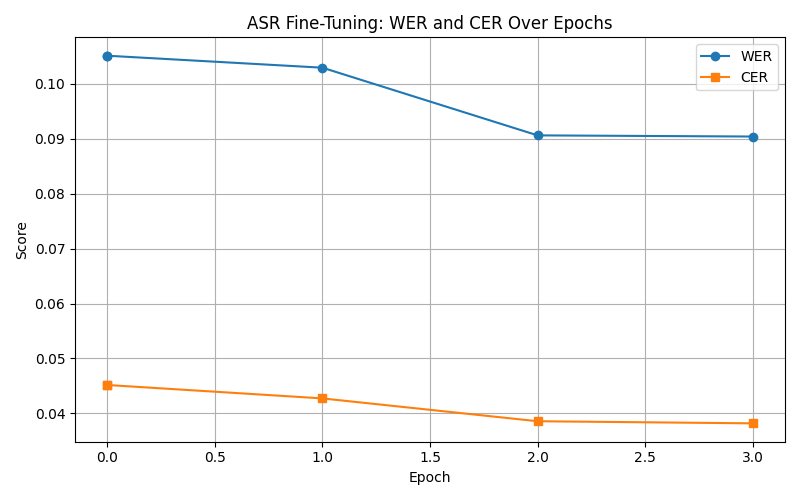

Both WER and CER metrics are decreasing with increasing epochs, showing that the model is performing better with epoch number.

In [ ]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(combined_df["epoch"], combined_df["wer"], label="WER", marker="o")
plt.plot(combined_df["epoch"], combined_df["cer"], label="CER", marker="s")
plt.title("ASR Fine-Tuning: WER and CER Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("wer_cer_plot.png")
plt.show()


## Plot train/val loss vs. epoch
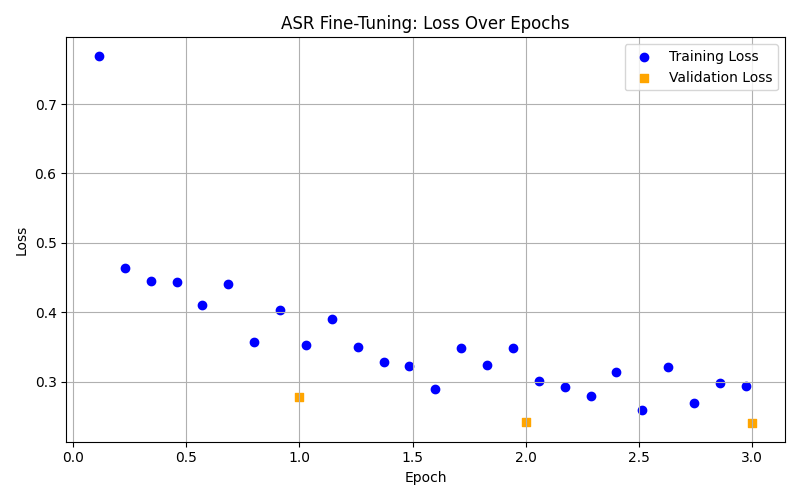

Both training loss and validation loss are decreasing with increasing epochs, which typically indicates that the model is learning relevant patterns in the data and generalizing well — at least up to 3 epochs.
The absence of a divergence between training and validation loss further indicates that overfitting has not yet occurred, and additional training may still yield performance gains.

In [ ]:
# Access loss logs from Trainer state
log_history = trainer.state.log_history

# Extract training and evaluation losses
loss_data = {
    "epoch": [],
    "training_loss": [],
    "eval_loss": []
}

for log in log_history:
    if "loss" in log and "epoch" in log:
        loss_data["epoch"].append(log["epoch"])
        loss_data["training_loss"].append(log["loss"])
        loss_data["eval_loss"].append(None)  # Placeholder for eval loss
    elif "eval_loss" in log and "epoch" in log:
        # Match epoch index for eval loss
        loss_data["epoch"].append(log["epoch"])
        loss_data["training_loss"].append(None)
        loss_data["eval_loss"].append(log["eval_loss"])

# Convert to DataFrame
loss_df = pd.DataFrame(loss_data)
loss_df.sort_values("epoch", inplace=True)
loss_df.to_csv("loss_history.csv", index=False)

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(loss_df["epoch"], loss_df["training_loss"], label="Training Loss", color="blue", marker='o')
plt.scatter(loss_df["epoch"], loss_df["eval_loss"], label="Validation Loss", color="orange", marker='s')
plt.title("ASR Fine-Tuning: Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("train_val_loss_plot.png")
plt.show()



## Save finetuned model

In [ ]:
save_dir = "wav2vec2-large-960h-cv"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

print(f"Fine-tuned model saved as '{save_dir}'")


# cv-valid-test evaluation

## Load finetuned model

In [ ]:
# Load fine-tuned model
model = Wav2Vec2ForCTC.from_pretrained("wav2vec2-large-960h-cv")
processor = Wav2Vec2Processor.from_pretrained("wav2vec2-large-960h-cv")
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Normalize text
def normalize_text(text):
    text = re.sub(r"<unk>", "", text, flags=re.IGNORECASE)
    text = text.upper().strip()
    text = re.sub(r"[^A-Z' ]+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

## Load test dataset

In [ ]:
# Load test CSV
test_df = pd.read_csv("../data/cv-valid-test.csv")
test_df["normalized_text"] = test_df["text"].apply(normalize_text)
DATA_DIR_TEST = "../data/cv-valid-test"

## Inference of test dataset 

In [ ]:
ground_truths = []
predictions = []

for row in tqdm(test_df.itertuples(), total=len(test_df)):
    file_path = os.path.join(DATA_DIR_TEST, row.filename)
    true_text = row.normalized_text

    # Load audio
    audio, sr = sf.read(file_path)
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    audio = audio / np.max(np.abs(audio))

    # Run inference
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred_ids = torch.argmax(logits, dim=-1)
    pred_text = processor.batch_decode(pred_ids)[0]
    pred_text = normalize_text(pred_text)

    predictions.append(pred_text)
    ground_truths.append(true_text)


## Save performance metrics

In [ ]:
final_wer = wer(ground_truths, predictions)
final_cer = cer(ground_truths, predictions)

print(f"\nTest Set Evaluation:")
print(f"WER: {final_wer:.4f}")
print(f"CER: {final_cer:.4f}")

# Save to CSV
results_df = pd.DataFrame([{
    "split": "test",
    "wer": final_wer,
    "cer": final_cer
}])

results_df.to_csv("test_set_metrics.csv", index=False)
print("\nMetrics saved to test_set_metrics.csv")

# cv-valid-dev evaluation

## Finetuned model

### Load dev dataset

In [ ]:
# Load test CSV
dev_df = pd.read_csv("../data/cv-valid-dev.csv")
dev_df["normalized_text"] = dev_df["text"].apply(normalize_text)
DATA_DIR_DEV = "../data/cv-valid-dev"


### Inference of dev dataset

In [ ]:
ground_truths = []
predictions = []

for row in tqdm(dev_df.itertuples(), total=len(dev_df)):
    file_path = os.path.join(DATA_DIR_DEV, row.filename)
    true_text = row.normalized_text

    # Load audio
    audio, sr = sf.read(file_path)
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    audio = audio / np.max(np.abs(audio))

    # Run inference
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred_ids = torch.argmax(logits, dim=-1)
    pred_text = processor.batch_decode(pred_ids)[0]
    pred_text = normalize_text(pred_text)

    predictions.append(pred_text)
    ground_truths.append(true_text)


### Save performance metrics

In [ ]:
final_wer = wer(ground_truths, predictions)
final_cer = cer(ground_truths, predictions)

print(f"\n Finetuned Dev Set Evaluation:")
print(f"WER: {final_wer:.4f}")
print(f"CER: {final_cer:.4f}")

# Save to CSV
results_df = pd.DataFrame([{
    "split": "dev",
    "wer": final_wer,
    "cer": final_cer
}])

results_df.to_csv("finetuned_dev_set_metrics.csv", index=False)
print("\n Metrics saved to finetuned_dev_set_metrics.csv")

## Baseline model

### Load baseline model

In [ ]:
# Load baseline pretrained model and processor
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

# Set model to evaluation mode and move to GPU if available
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")


### Inference of dev dataset

In [ ]:
ground_truths = []
predictions = []

for row in tqdm(dev_df.itertuples(), total=len(dev_df)):
    file_path = os.path.join(DATA_DIR_DEV, row.filename)
    true_text = row.normalized_text

    # Load audio
    audio, sr = sf.read(file_path)
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
    audio = audio / np.max(np.abs(audio))

    # Run inference
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred_ids = torch.argmax(logits, dim=-1)
    pred_text = processor.batch_decode(pred_ids)[0]
    pred_text = normalize_text(pred_text)

    predictions.append(pred_text)
    ground_truths.append(true_text)

### Save performance metrics

In [ ]:
final_wer = wer(ground_truths, predictions)
final_cer = cer(ground_truths, predictions)

print(f"\n Baseline Dev Set Evaluation:")
print(f" WER: {final_wer:.4f}")
print(f" CER: {final_cer:.4f}")

# Save to CSV
results_df = pd.DataFrame([{
    "split": "dev",
    "wer": final_wer,
    "cer": final_cer
}])

results_df.to_csv("baseline_dev_set_metrics.csv", index=False)
print("\n Metrics saved to baseline_dev_set_metrics.csv")